<a href="https://colab.research.google.com/github/nov05/Google-Colaboratory/blob/master/20250604_map_reduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Notebook modified by nov05 on 2025-06-04  

In [2]:
!pip install langchain_google_vertexai langchain_core langgraph
## Successfully installed httpx-sse-0.4.0 langchain_google_vertexai-2.0.24 langgraph-0.4.8 langgraph-checkpoint-2.0.26
## langgraph-prebuilt-0.2.2 langgraph-sdk-0.1.70 ormsgpack-1.10.0 pyarrow-19.0.1 validators-0.35.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.oauth2 import service_account
json_path = "/content/drive/MyDrive/config/20250604_google_service_account_key-lucid-bebop-461722-c5-a91d4ab1be75.json"
credentials = service_account.Credentials.from_service_account_file(json_path)
print(credentials)

# 🟢 **Handling a long input**  

Find a long video you'd like to process and put it on GCS:

In [10]:
%%time
import os
from google.colab import userdata
import google.generativeai as genai

## watch the funny animation here
video_uri = "https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4"
!wget {video_uri} -O video.mp4

# genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))  ## ❌ works for GenAI only
# video_file_name = "video.mp4"
# print(f"Uploading file...")
# video_file = genai.upload_file(path=video_file_name)
# video_uri = video_file.uri
# print(f"Completed upload: {video_uri}")

--2025-06-05 05:16:04--  https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4
Resolving download.blender.org (download.blender.org)... 172.67.14.163, 104.22.65.163, 104.22.64.163, ...
Connecting to download.blender.org (download.blender.org)|172.67.14.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64657027 (62M) [video/mp4]
Saving to: ‘video.mp4’

video.mp4           100%[===================>]  61.66M   129MB/s    in 0.5s    

2025-06-05 05:16:05 (129 MB/s) - ‘video.mp4’ saved [64657027/64657027]

Uploading file...
Completed upload: https://generativelanguage.googleapis.com/v1beta/files/1002rd0d7n58
CPU times: user 1.48 s, sys: 280 ms, total: 1.76 s
Wall time: 7.51 s


In [16]:
from google.cloud import storage

project = "lucid-bebop-461722-c5"
bucket_name = "generative_ai_with_langchain"
blob_name = "video.mp4"
client = storage.Client(project=project, credentials=credentials)
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.upload_from_filename("video.mp4")
## (Optional) Make it public - ❌ This won't work for VertexAI respects crawling rules.
# blob.make_public()
# video_uri = blob.public_url
## Use this URI if not public but accessible to Vertex AI
video_uri = f"gs://{bucket_name}/{blob_name}"  ## ✅
print("Video URI:", video_uri)

Video URI: gs://generative_ai_with_langchain/video.mp4


## 👉 **Using LangChain**  

In [46]:
%%time
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_google_vertexai import ChatVertexAI
from langchain_core.runnables import RunnableLambda

def _create_input_messages(*, video_uri:str, chunks:int=9, interval_secs:int=10):
    video_parts = []
    for start_offset in range(chunks):
        part = {
            "type": "media", "file_uri": video_uri, "mime_type": "video/mp4",
            "video_metadata": {
                "start_offset": {"seconds": start_offset * interval_secs},
                "end_offset": {"seconds": (start_offset+1) * interval_secs}
            }
        }
        video_parts.append(part)
    return [[HumanMessage(content=[human_part, vp])] for vp in video_parts]

human_part = {"type": "text", "text": "Provide a summary of the video."}
input_messages = _create_input_messages(video_uri=video_uri)
## https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-0-flash
llm = ChatVertexAI(
    model="gemini-2.0-flash-001",
    project="lucid-bebop-461722-c5",  ## ✅ mandatory
    credentials=credentials           ## ✅ mandatory
)
chain = llm | StrOutputParser()
# summaries = chain.batch(input_messages, config={"max_concurrency": 3})
create_inputs_chain = RunnableLambda(lambda x: _create_input_messages(**x))
map_chain = create_inputs_chain | RunnableLambda(lambda x: chain.batch(x, config={"max_concurrency": 3}))
summaries = map_chain.invoke({"video_uri": video_uri})

CPU times: user 163 ms, sys: 40.6 ms, total: 204 ms
Wall time: 10.1 s


Let's define a function to merge summaries together:

In [47]:
%%time
from langchain_core.prompts import PromptTemplate
from IPython.display import Markdown, display

def _merge_summaries(summaries:list[str], interval_secs:int=10, **kwargs) -> str:
    sub_summaries = []
    for i, summary in enumerate(summaries):
        sub_summary = (
            f"Summary from sec {i*interval_secs} to sec {(i+1)*interval_secs}:"
            f"\n{summary}\n")
        sub_summaries.append(sub_summary)
    return "".join(sub_summaries)

reduce_prompt = PromptTemplate.from_template(
    "You are given a list of summaries that "
    "of a video splitted into sequential pieces.\n"
    "SUMMARIES:\n{summaries}"
    "Based on that, prepare a summary of a whole video."
)
reduce_chain = RunnableLambda(lambda x: _merge_summaries(**x)) | reduce_prompt | llm | StrOutputParser()
final_summary = reduce_chain.invoke({"summaries": summaries})
display(Markdown(final_summary))

The video opens with a bright, cartoon landscape and introduces a pudgy bird who quickly falls asleep on a tree branch. The title cards for "The Peach Open Movie Project Presents" and "Big Buck Bunny" appear, followed by a view of Big Buck Bunny's burrow. The camera zooms in to reveal a rabbit sleeping inside. The rabbit wakes up, stretches, and emerges from its burrow into a sunny forest. He enjoys the beautiful day, admiring white flowers in a lush green field. He then lays on his back, smiling, as a butterfly lands on his ear. Later, the rabbit is seen in a field, seemingly contemplating or meditating, when an apple falls nearby, which he picks up to examine.


CPU times: user 20.4 ms, sys: 0 ns, total: 20.4 ms
Wall time: 1.24 s


👉 Video summary example:  

**Google Cast: Evolution and Future - A Comprehensive Summary**  

This video, featuring Majd Bakar and John Affaki, explores the evolution of Google Cast and provides insights into its future direction.

**Introduction (0-600 seconds):**

The video begins by highlighting the success of Chromecast, a revolutionary $35 device that extends content from mobile devices to HDTVs. The Google Cast SDK and developer program, boasting over 6,000 developers, have been instrumental in expanding the casting ecosystem. The core vision for Google Cast revolves around: redefining interaction models with television (moving away from cumbersome experiences with technologies like gyroscopes and cameras), building a robust ecosystem, ensuring an open platform, and delivering a consistent user experience.  The ubiquity of mobile devices allows developers to focus on function without compromising form. The SDK is available for Android, iOS, and Web Apps in Chrome, and over 50% of Chromecast users utilize multiple platforms.  Key application areas include media streaming (video, music), and photo displays. This content can be served from the Cloud, a mobile device, or a local network. The architecture also supports multiple mobile devices connecting to a single session, enabling collaborative features like party modes, voting, and content sharing.

**New Features and Functionality (600-1200 seconds):**

The video showcases features like multi-player games (e.g., Big Web Quiz) and the Chromecast home screen displaying dynamic content.  The Chromecast home screen provides context-aware information to users interacting with their phones. John Affaki, leading the Google Cast SDK team, discusses upcoming features including:

*   **Cast to nearby devices:** Allowing casting without requiring devices to be on the same Wi-Fi network.
*   **Android TV integration:**  Bringing the same Google Cast functionality found in Chromecast to Android TV, enabling projection of Android apps onto the big screen without requiring extensive developer modifications.
*   **Media library improvements:** Including accessibility enhancements for the hearing impaired.

**Developer Focus and Future Directions (1200-1800 seconds):**

The video focuses on improvements for developers, including:

*   **Standardized Queuing API:**  Simplifying the creation, modification, and management of media item queues, replacing the need for individual apps to implement their own solutions.
*   **Full Featured Media Controls:**  Providing a consistent experience for interacting with media playback from any device.
*   **Secure Credential Transfer:**  Offering a secure method for transferring authentication credentials between sender and receiver for seamless service access within Google Cast. This is integrated with the queuing API, allowing for different credentials for different items in the queue.
*   **Improved App Discovery:**  Enhancing app discovery through a redesigned chromecast.com/apps website and an updated developer console for data gathering.
*   **Expanding Beyond Media:**  Exploring innovative applications beyond media and gaming and encouraging developers to provide feedback.

**Q&A: Addressing Developer Concerns (1800-3000 seconds):**

The video transitions to a Q&A session where developers raise various issues:

*   **Local Content Streaming:** Addressing how to stream local content to Chromecast by utilizing cloud-accessible URLs. Developers are advised to opt-out of local discovery in the development console.
*   **Audio/Video Latency:** Acknowledging the beta status of Android mirroring and efforts to minimize audio and video latency, especially for gaming.
*   **HMICEC Control:**  Clarifying that application control is not a platform limitation.
*   **Feature Timelines:**  While specific timelines are not provided, it is indicated that closed caption APIs are released, and screen casting/closed captioning within Google Play Services would be rolled out within a few weeks.
*   **"Screensaver" Integration:** Discussing how the presentation API in Android provides similar functionalities for seamless resumption, though not a full replacement for backdrop functionality.
*   **Cross-Domain Policies, Wi-Fi Security, and Android TV Hardware:** Addressing technical questions related to cross-domain policies, Wi-Fi security protocols, and hardware differences between Chromecast and Android TV. The lack of Google Play services on Amazon Kindle Fire is also mentioned.

**Conclusion:**

The video concludes with the presenters thanking the audience and announcing a Chromecast giveaway, highlighting Google's commitment to fostering a thriving Google Cast developer community. The overall message is that Google Cast is continuously evolving, with a focus on improving user experience, simplifying developer integration, and expanding beyond traditional media applications.  

Let's implement a reduce step that merges intermediatesummaries together:

In [48]:
%%time
from langchain_core.runnables import RunnablePassthrough
## The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0.
## Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
# from langchain.chains import LLMChain
reduce_chain = (
    RunnableLambda(lambda x: _merge_summaries(**x)) |
    # LLMChain(llm=llm, prompt=reduce_prompt, output_parser=StrOutputParser())
    reduce_prompt | llm | StrOutputParser()
)
final_chain = (
    RunnablePassthrough.assign(summaries=map_chain).assign(final_summary=reduce_chain) |
    RunnableLambda(lambda x: x["final_summary"])
)
result = final_chain.invoke({
    "video_uri": video_uri, "interval_secs": 65, "chunks": 9})  ## almost full length
result

CPU times: user 163 ms, sys: 41.4 ms, total: 204 ms
Wall time: 15.7 s


'"Big Buck Bunny" opens with serene nature scenes before introducing the titular character, a large, fluffy rabbit. Initially enjoying the peaceful meadow, Big Buck Bunny\'s tranquility is disrupted by a trio of mischievous squirrels who harass him by dropping things on his head. This instigates a shift in the bunny\'s demeanor, transforming him into a stern, vengeful figure. He retreats into the forest, crafts weapons and traps, and retaliates against the squirrels and a mouse, trapping them in a pit. Later, he thwarts a flying squirrel\'s attempt to reach an apple by encircling the tree with sharp sticks. The bunny then captures a small furry animal and uses it as a kite. The video concludes with the end credits, which acknowledge the creative and financial contributors of this film. During the credits, animated characters make an appearance and the video ends with a scene that includes the flying squirrel and a bird.\n'

In [49]:
display(Markdown(result))

"Big Buck Bunny" opens with serene nature scenes before introducing the titular character, a large, fluffy rabbit. Initially enjoying the peaceful meadow, Big Buck Bunny's tranquility is disrupted by a trio of mischievous squirrels who harass him by dropping things on his head. This instigates a shift in the bunny's demeanor, transforming him into a stern, vengeful figure. He retreats into the forest, crafts weapons and traps, and retaliates against the squirrels and a mouse, trapping them in a pit. Later, he thwarts a flying squirrel's attempt to reach an apple by encircling the tree with sharp sticks. The bunny then captures a small furry animal and uses it as a kite. The video concludes with the end credits, which acknowledge the creative and financial contributors of this film. During the credits, animated characters make an appearance and the video ends with a scene that includes the flying squirrel and a bird.


👉 Example summary:   

"Big Buck Bunny" is an animated short film that follows a large, gentle rabbit's experiences in a forest meadow. Initially, he enjoys the peaceful surroundings, but his tranquility is disrupted by a group of mischievous rodents – squirrels and a chinchilla. They steal from him and throw things at him, leading to comical revenge plots.

The rabbit attempts to trap the squirrels using various tools and contraptions, leading to slapstick scenarios involving bombs, booby traps, and chases through the forest. The conflict escalates with squirrels becoming victims of the rabbit's traps. The video culminates with one of the squirrels flying through the air with a kite string, held by the rabbit. The film then transitions to the credits, featuring animated squirrels and rodents in the background. The story blends humor and mild violence in a lighthearted animated style.

## 👉 Using LangGraph

Let's implement the same logic using LangGraph:

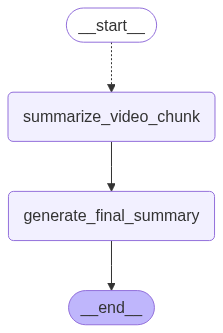

In [69]:
import operator
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    video_uri: str
    chunks: int
    interval_secs: int
    summaries: Annotated[list, operator.add]
    final_summary: str

class _ChunkState(TypedDict):
    video_uri: str
    start_offset: int
    interval_secs: int

## ⚠️ I'm not sure if the model takes the metadata into account during summarization.
# human_part = {"type": "text", "text": "Provide a summary of the video."}

async def _summarize_video_chunk(state:  _ChunkState):
    start_offset = state["start_offset"]
    interval_secs = state["interval_secs"]
    start_sec = start_offset * interval_secs
    end_sec = (start_offset+1) * interval_secs
    human_part = {
        "type": "text",
        "text": f"Provide a summary of the video between seconds {start_sec} and {end_sec}."
    }
    video_part = {
        "type": "media", "file_uri": state["video_uri"], "mime_type": "video/mp4",
        "video_metadata": {
            "start_offset": {"seconds": start_sec},
            "end_offset": {"seconds": end_sec},
        }
    }
    response = await llm.ainvoke(
        [HumanMessage(content=[human_part, video_part])])
    return {"summaries": [response.content]}

def _map_summaries(state: AgentState):
    chunks = state["chunks"]
    payloads = [
        {
            "video_uri": state["video_uri"],
            "interval_secs": state["interval_secs"],
            "start_offset": i
        } for i in range(state["chunks"])
    ]
    return [Send("summarize_video_chunk", payload) for payload in payloads]

async def _generate_final_summary(state: AgentState):
    summary = _merge_summaries(
        summaries=state["summaries"], interval_secs=state["interval_secs"])
    final_summary = await (reduce_prompt | llm | StrOutputParser()).ainvoke({"summaries": summary})
    return {"final_summary": final_summary}

graph = StateGraph(AgentState)
graph.add_node("summarize_video_chunk", _summarize_video_chunk)
graph.add_node("generate_final_summary", _generate_final_summary)

graph.add_conditional_edges(START, _map_summaries, ["summarize_video_chunk"])
graph.add_edge("summarize_video_chunk", "generate_final_summary")
graph.add_edge("generate_final_summary", END)

app = graph.compile()
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [70]:
result = await app.ainvoke(
    {"video_uri": video_uri, "chunks": 9, "interval_secs": 65},
    {"max_concurrency": 3}
)
result["final_summary"]

'Big Buck Bunny opens with a scenic view of a green valley. Big Buck Bunny awakens from his burrow, enjoying the flowers and sunshine. He attempts to befriend a butterfly, unknowingly casting a shadow on a sleeping squirrel. This leads to the squirrel and his companions retaliating by dropping fruit and acorns on Big Buck.\n\nFueled by this attack, the squirrels plot revenge, experimenting with flight using butterfly wings, which ends in failure. They resort to throwing spiky fruit at the rabbit. This escalates when the rabbit crafts a spear, signaling the start of a war.\n\nThe rabbit sets up a vine trap with sharpened sticks, ensnaring several squirrels and a mouse. The tables turn when the booby trap is used against Big Buck, and then accidentally launches a chinchilla into the sky. A bird becomes the target of a pea shooter.\n\nThe squirrels continue their attack with traps. One squirrel glides through the air, attempting to dislodge an apple. However, the apple falls and triggers 

In [71]:
display(Markdown(result['final_summary']))

Big Buck Bunny opens with a scenic view of a green valley. Big Buck Bunny awakens from his burrow, enjoying the flowers and sunshine. He attempts to befriend a butterfly, unknowingly casting a shadow on a sleeping squirrel. This leads to the squirrel and his companions retaliating by dropping fruit and acorns on Big Buck.

Fueled by this attack, the squirrels plot revenge, experimenting with flight using butterfly wings, which ends in failure. They resort to throwing spiky fruit at the rabbit. This escalates when the rabbit crafts a spear, signaling the start of a war.

The rabbit sets up a vine trap with sharpened sticks, ensnaring several squirrels and a mouse. The tables turn when the booby trap is used against Big Buck, and then accidentally launches a chinchilla into the sky. A bird becomes the target of a pea shooter.

The squirrels continue their attack with traps. One squirrel glides through the air, attempting to dislodge an apple. However, the apple falls and triggers sharpened stake traps, causing the squirrel to crash.

Eventually, Big Buck catches a tree shrew. He then witnesses the tree shrew transformed into a kite being carried through the sky, and smiles at the audience. Finally, the credits roll, showcasing the team behind the project, accompanied by appearances from the film's characters, and the film's title "Big Buck Bunny" is displayed.


👉 Final summanry example:  

Okay, here's a comprehensive summary of the entire video, synthesized from the individual section summaries:

**Overall Video Summary:**

The video features Google Engineers Majid Abakar and John Afaki discussing the evolution of Google Cast and its future direction. They highlight Google Cast's goals: redefining TV interaction, offering compelling large-screen experiences, building an open and consistent ecosystem for both users and developers.

The presentation covers several key areas:

*   **Introduction to Google Cast:** It started with Chromecast for $35 and now encompasses a broader vision of bringing content to the largest screen possible using mobile devices as controllers.
*   **Interaction Model:** Focuses on seamless content consumption on large screens, leveraging mobile device portability. The user can use the cloud, their mobile device or the local cloud on other devices. With the ability to connect multiple mobile devices to a single session, this media app can bring great use cases such as party mode, voting and sharing content.
*   **Developer Focus:** Emphasizes ease of development using HTML5 and JavaScript, with UX guidelines for consistent user experiences.
*   **New Features and Updates:**
    *   Casting to nearby devices without Wi-Fi using location and ultrasound.
    *   Android TV integration with Cast functionalities.
    *   Updated Google Cast SDK supporting Smooth Stream, Dash, and HLS.
    *   Enhanced Closed Captioning support.
    *   Unified queue management API with functions for insert, remove, and reorder.
    *   Media controls on mobile devices for interacting with playing media even without the app.
    *   Improved app discovery through a redesigned Chromecast.com/apps website and a new developer console.
*   **Beyond Media:** Explores uses beyond media, including games, education, and business applications like presentations and digital signage.
*   **Q&A Session:**
    *   Discusses streaming local vs. foreign content.
    *   Addresses user opt-out of local discovery.
    *   Mentions casting from a desktop (experimental feature).
    *   Discusses primitives for images and slideshows.
    *   Explores the possibility of playing music and streaming photos simultaneously on Android TV (currently not planned).
    *   Addresses audio and video latency with Android mirroring (goal of low latency).
    *   Covers the option for individual applications to disable video display on the big screen (system function controlled at the level of protection).
    *   Confirms Cross Domain Auth is not going away.
    *   Mentions considerations for 5 GHz support (cannot discuss future hardware).
    *   States codec support will be identical on Chromecast and Android TV.
    *   Addresses Kindle Fire compatibility (SDK not available due to Google Play Services dependency).

The video concludes with the announcement of free Chromecasts being given away. In essence, the video provides an overview of Google Cast's current state, future enhancements, and its expanding role in various application areas.


In [92]:
## executing the LangGraph app again
async for step in app.astream(
    {"video_uri": video_uri, "chunks": 9, "interval_secs": 65},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['generate_final_summary']


In [85]:
## executing the LangGraph app again
chunk_summaries = []
async for step in app.astream(
    {"video_uri": video_uri, "chunks": 9, "interval_secs": 65},
    {"recursion_limit": 10},
):
    print(list(step.values()))
    for val in step.values():
        if isinstance(val, dict) and "summaries" in val:
            chunk_summaries.append(val["summaries"])

[{'summaries': ['Sure, here is a summary of the clip.\n\nThe squirrel plans on taking an apple, which is on the other side of some sharp stakes. He prepares to fly over it as the bunny watches. The squirrel flies over the stakes, but gets caught at the other end. The bunny watches the squirrel struggle to get free.']}]
[{'summaries': ['The squirrel, rabbit, and chinchilla are in a forest, and they attempt to use a catapult. But, when the rabbit sets off the catapult, the projectile flies up into the sky, and then comes down, landing next to the chinchilla. The chinchilla is picked up in a trap set by the rabbit. A squirrel and a bird on a tree are spectators of the ordeal.']}]
[{'summaries': ['The summary for the video between seconds 65 and 130:01:05 is as follows: A white rabbit smells flowers and rolls around in a field of grass. A butterfly lands on the rabbit. The rabbit gets up, and an apple drops from a tree. The rabbit picks up the apple, and then tosses it down and walks to th

In [88]:
md = ""
for i, chunk_summary in enumerate(chunk_summaries):
    # Replace newlines with <br> for wrapping
    md_summary = str(chunk_summary[0]).replace('\n', '<br>')
    md += f"**{i}.**<br>{md_summary}<br><br>"
display(Markdown(md))

**0.**<br>Sure, here is a summary of the clip.<br><br>The squirrel plans on taking an apple, which is on the other side of some sharp stakes. He prepares to fly over it as the bunny watches. The squirrel flies over the stakes, but gets caught at the other end. The bunny watches the squirrel struggle to get free.<br><br>**1.**<br>The squirrel, rabbit, and chinchilla are in a forest, and they attempt to use a catapult. But, when the rabbit sets off the catapult, the projectile flies up into the sky, and then comes down, landing next to the chinchilla. The chinchilla is picked up in a trap set by the rabbit. A squirrel and a bird on a tree are spectators of the ordeal.<br><br>**2.**<br>The summary for the video between seconds 65 and 130:01:05 is as follows: A white rabbit smells flowers and rolls around in a field of grass. A butterfly lands on the rabbit. The rabbit gets up, and an apple drops from a tree. The rabbit picks up the apple, and then tosses it down and walks to the tree. A group of three squirrels watch the rabbit from afar. The rabbit goes to the tree, and a butterfly lands on its head. One of the squirrels sleeps at the bottom of the tree next to the rabbit.<br><br>**3.**<br>Here is a summary of the video from 00:03:15 to 00:04:20.<br><br>The bunny continues to be terrorized by a squirrel and his friends. They begin by taking the wings off a butterfly, so it can't fly. They then throw fruit and spiked green seed pods at the bunny. This prompts the bunny to run away and hide behind a tree. The squirrels are waiting for him and they begin throwing more spiked green seed pods at the tree the bunny is hiding behind.  The bunny gets mad and then carves a weapon and begins to hunt down the squirrels.<br><br>**4.**<br>Between 00:04:20 and 00:05:25, the large rabbit is setting a trap, including a trip wire and camouflaged pitfall. The three squirrels walk into the trap and fall into the pit, where the rabbit looks down on them with malevolence. The rabbit readies his bow and arrow to shoot them in the pitfall.<br><br>**5.**<br>The video begins with a dark, blurry image that gradually clears to reveal a cartoon landscape consisting of grassy hills, trees, and pink clouds. The scene then transitions to a close-up view of a stream. A cartoon bird chirps happily on a branch, then looks sleepy as it tries to get comfortable. The title card reads "THE PEACH OPEN MOVIE PROJECT PRESENTS," followed by "Big Buck BUNNY." The scene shifts to the outside of a large burrow under a tree, and then close in to a large rabbit sleeping in the burrow. He wakes up, comes out of his burrow, stretches, and looks around at the sunny day.<br><br>**6.**<br>Here is a summary of the video between the noted timestamps:<br><br>The video displays the credits for Big Buck Bunny, an animated short film. They are displayed on a green background, that gradually transitions to grey, and eventually black. Throughout the sequence, animated characters walk across the screen, either individually or in groups. The final credit displays that Big Buck Bunny has been realized with financial support from the Digital Pioneers fund and the Blender Foundation and produced by Ton Roosendaal. The video is licensed as a creative commons attribute 3.0, and its website address is displayed. The credits fade to black, and the viewer sees the final scene of Big Buck Bunny, featuring Gimera, a lemur-like character and bird.<br><br>**7.**<br>Here is the summary of the video between 455 and 520 seconds: <br><br>At the beginning of the clip, the bunny picks up the rodent and smiles menacingly. After a brief pause, the clip cuts to a daytime field where the bunny is seen with a pink butterfly landing on its face. The bunny is holding a string while the rodent is attached to a kite. The video concludes with the credits from the movie, and the rodent and chinchilla are seen playing with each other.<br><br>**8.**<br>Sure! Here is a summary of the video between seconds 1:30 and 2:10.<br><br>The gray rabbit stands under a tree. Suddenly, an angry, cartoon-like squirrel appears from behind the tree, with an equally weird-looking, red squirrel hanging upside down from a tree limb overhead. Then a butterfly lands on the rabbit's nose. The red squirrel climbs down from the limb. They all, along with a dark gray hedgehog who is holding a nut, gather behind the trunk of the tree. Then they begin pelting the rabbit with nuts and fruit, one by one, in a rhythm. At the end, the squirrel in charge is poised to throw a snowball at the butterfly.<br><br>

Let's look at the final summary:

In [90]:
step.values()

dict_values([{'final_summary': "Big Buck Bunny Summary:\n\nThe video opens with a cheerful cartoon landscape where Big Buck Bunny, a large rabbit, awakens and emerges from his burrow to enjoy a sunny day. He frolics in a field, attracting the attention of three mischievous squirrels and a hedgehog. These bullies begin pelting the bunny with nuts and fruit, escalating to cruel acts like removing a butterfly's wings. Enraged, Big Buck Bunny plots his revenge.\n\nHe sets elaborate traps, including a pitfall and a catapult. The squirrels fall into the pit, but when the catapult is triggered, the projectile accidentally traps a chinchilla. The bunny continues his pursuit of the squirrel, leading to a scene where the squirrel tries to steal an apple across a field of stakes but gets caught.\n\nThe bunny then picks up the rodent and smiles menacingly. The scene shifts to a more peaceful resolution. The bunny is seen with a pink butterfly on its face, holding a string attached to the rodent, w

In [91]:
display(Markdown(list(step.values())[0]['final_summary']))

Big Buck Bunny Summary:

The video opens with a cheerful cartoon landscape where Big Buck Bunny, a large rabbit, awakens and emerges from his burrow to enjoy a sunny day. He frolics in a field, attracting the attention of three mischievous squirrels and a hedgehog. These bullies begin pelting the bunny with nuts and fruit, escalating to cruel acts like removing a butterfly's wings. Enraged, Big Buck Bunny plots his revenge.

He sets elaborate traps, including a pitfall and a catapult. The squirrels fall into the pit, but when the catapult is triggered, the projectile accidentally traps a chinchilla. The bunny continues his pursuit of the squirrel, leading to a scene where the squirrel tries to steal an apple across a field of stakes but gets caught.

The bunny then picks up the rodent and smiles menacingly. The scene shifts to a more peaceful resolution. The bunny is seen with a pink butterfly on its face, holding a string attached to the rodent, who is flying as a kite. The film concludes with credits rolling, showcasing animated characters, and ending with a final scene of the rodent and chinchilla playing together, suggesting a resolution of the conflict. The credits highlight the film's production details, its licensing, and the organizations that supported its creation. The film ends with a final scene of Gimera, a lemur-like character, and a bird.
